In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import warnings
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from quantnn.qrnn import QRNN
from quantnn.models.pytorch.logging import TensorBoardLogger

from load_data import GOESRETRIEVALSDataset, RandomCrop, Mask, Standardize, ToTensor
from visualize.sample_plots import plotRandomSample
 
from models.FirstGenericNet import Net 
net_name = 'FirstGenericNet' 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# SETUP
channels = [8, 13]
fillvalue = -1

n_epochs = 20
BATCH_SIZE = 16

quantiles = [0.25, 0.5, 0.75] #[0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

In [15]:
# PATHS TO DATA
path_to_data = 'dataset/data/dataset-boxes/'
path_to_save_model = 'models/saved_models/'

In [4]:
path_to_train_data = path_to_data + 'train/npy_files'
path_to_stats = os.path.join(Path(path_to_train_data).parent, Path('stats.npy'))

path_to_val_data = path_to_data + 'validation/npy_files'

path_to_test_data = path_to_data + 'test/npy_files'

In [5]:
def importData(channels, BATCH_SIZE, path_to_data, path_to_stats):
    dataset = GOESRETRIEVALSDataset(
        path_to_data = path_to_data,
        channels = channels, 
        transform = transforms.Compose([Mask(), RandomCrop(128),
                                        Standardize(path_to_data, path_to_stats, channels),
                                        ToTensor()])
    )

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return(dataset, dataloader)

In [6]:
train_dataset, train_dataloader = importData(channels, BATCH_SIZE, path_to_train_data, path_to_stats)

In [7]:
val_dataset, val_dataloader = importData(channels, BATCH_SIZE, path_to_val_data, path_to_stats)

207

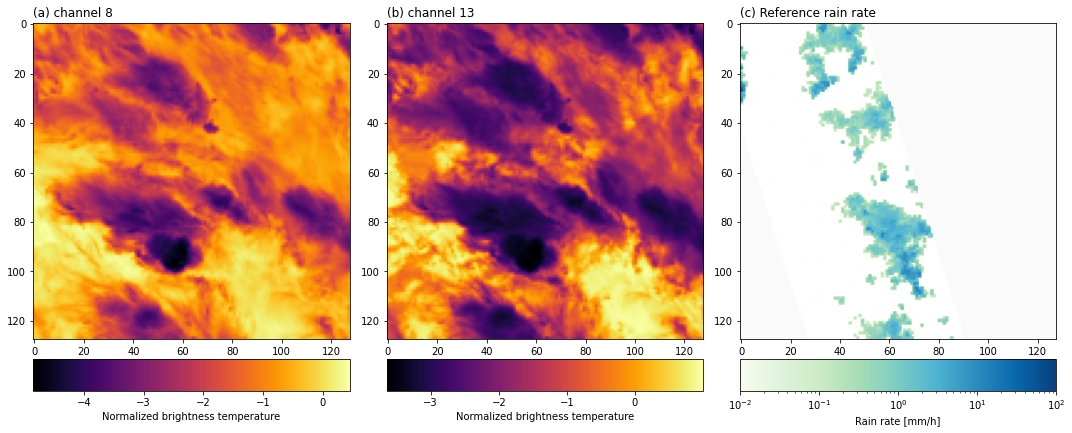

In [8]:
# PLOT RANDOM SAMPLE
plotRandomSample(train_dataset)

173

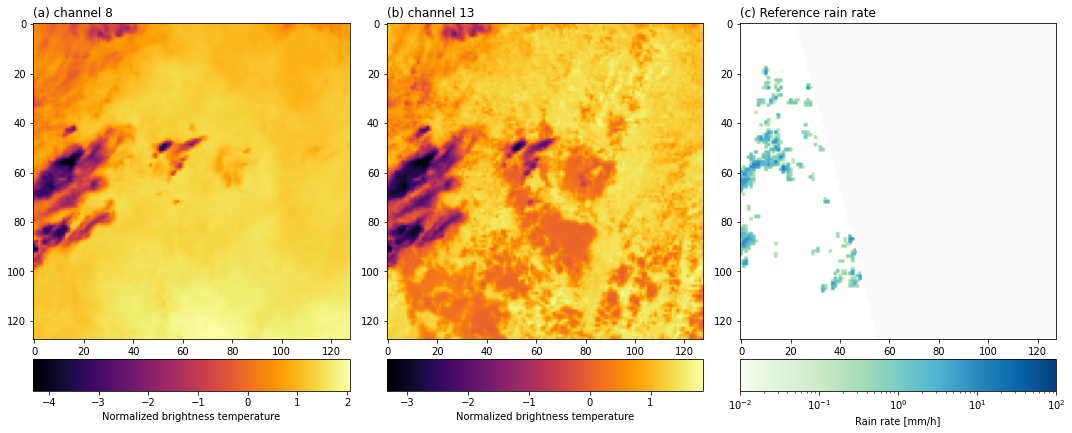

In [9]:
plotRandomSample(val_dataset)

In [10]:
net = Net(len(quantiles), len(channels))
qrnn_model = QRNN(quantiles=quantiles, model=net)
optimizer = SGD(net.parameters(), lr=0.1, momentum=0.9)

In [11]:
training_data = train_dataloader
validation_data = val_dataloader

In [12]:
log_directory = None
logger = TensorBoardLogger(n_epochs, log_directory=log_directory)

In [13]:
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.001)
qrnn_model.train(training_data=training_data,
              validation_data=validation_data,
              keys=("box", "label"),
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=fillvalue,
              device=device,
              logger=logger);
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.0001)
qrnn_model.train(training_data=training_data,
              validation_data=validation_data,
              keys=("box", "label"),
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=fillvalue,
              device=device,
              logger=logger);

Epoch  1 / 20: train. loss = 0.1444, val. loss = 0.1326, lr. = 0.1000, time = 72.146614 s
Epoch  2 / 20: train. loss = 0.1477, val. loss = 0.0988, lr. = 0.0994, time = 71.666156 s
Epoch  3 / 20: train. loss = 0.1326, val. loss = 0.0870, lr. = 0.0976, time = 70.988675 s
Epoch  4 / 20: train. loss = 0.1344, val. loss = 0.0957, lr. = 0.0946, time = 72.107994 s
Epoch  5 / 20: train. loss = 0.1232, val. loss = 0.0767, lr. = 0.0905, time = 73.704385 s
Epoch  6 / 20: train. loss = 0.1176, val. loss = 0.0661, lr. = 0.0855, time = 72.319005 s
Epoch  7 / 20: train. loss = 0.1130, val. loss = 0.0651, lr. = 0.0796, time = 73.501393 s
Epoch  8 / 20: train. loss = 0.1207, val. loss = 0.0679, lr. = 0.0730, time = 73.352952 s
Epoch  9 / 20: train. loss = 0.1130, val. loss = 0.0509, lr. = 0.0658, time = 74.360977 s
Epoch 10 / 20: train. loss = 0.1124, val. loss = 0.0563, lr. = 0.0582, time = 75.897497 s
Epoch 11 / 20: train. loss = 0.1081, val. loss = 0.0560, lr. = 0.0505, time = 109.318421 s
Epoch 12 

KeyboardInterrupt: 

In [17]:
# SAVE MODEL
qrnn_model.save(path_to_save_model+'qrnn_model')

0.5
index  41


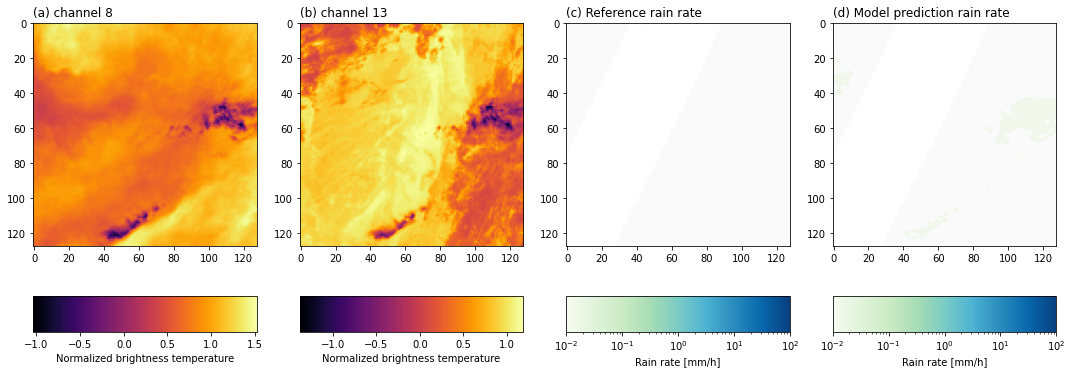

In [21]:
# PLOT RANDOM SAMPLE AND PREDICTION
quantile_num=int(len(quantiles)/2)
print(quantiles[quantile_num])
ind = plotRandomSample(val_dataset, net=net, quantile_num=quantile_num, device=device)
print('index ', ind)

In [20]:
quantile_num=int(len(quantiles)/2)
y_true = []
y_pred = []
with torch.no_grad():
    for batch_index, batch in enumerate(val_dataloader):

        y_true += [batch['label'].detach().numpy()]
        
        X = batch['box'].to(device).detach()
        y_pred += [net(X)[:,quantile_num].cpu().detach().numpy()]

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

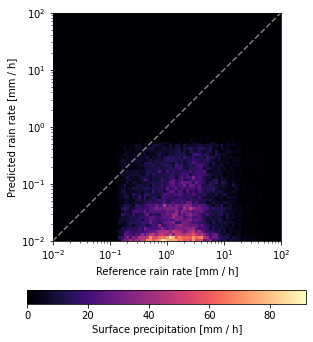

In [22]:
bins = np.logspace(-2, 2, 81)
indices = y_true >= 0.0


freqs, _, _ = np.histogram2d(y_true[indices], y_pred[indices], bins=bins)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)

f, axs = plt.subplots(figsize=(5, 6))

ax = axs
p = ax.pcolormesh(bins, bins, freqs.T,
                  #norm=norm,  
                  cmap=plt.get_cmap('magma'))
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
#ax.set_title("(a) Title", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
ax.set_aspect(1.0)


In [23]:
print('Non zero rain to all rain ratio (true): ', np.sum(y_true[indices]!=0.)/len(y_true[indices]))
print('Non zero rain to all rain ratio (pred): ', np.sum(y_pred[indices]!=0.)/len(y_pred[indices]))

TP = np.sum(y_pred[indices][(y_true[indices]!=0.)]!=0.)
FN = np.sum(y_pred[indices][(y_true[indices]!=0.)]==0.)
FP = np.sum(y_pred[indices][(y_true[indices]==0.)]!=0.)
TN = np.sum(y_pred[indices][(y_true[indices]==0.)]==0.)

TPR = TP/(TP+FN)
print(TPR)
FPR = FP/(FP+TN)
print(FPR)

ACC = (TP+TN)/(TP+FN+FP+TN)
print(ACC)

Non zero rain to all rain ratio (true):  0.04342898833337133
Non zero rain to all rain ratio (pred):  1.0
1.0
1.0
0.04342898833337133


In [24]:
print(len(y_true[indices]))
print(len(val_dataset))


1491262
238


In [25]:
(len(train_dataset))

998